In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/Users/MYK/Desktop/IRES/scripts')

import matplotlib.pyplot as plt
import numpy as np
import pywt
import scipy.stats
from collections import Counter

import fake_profile as fp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
amp_1 = [.006, .12, .015]; mu_1 = [47.5, 50, 52.5]; sd_1 = [.3, .4, .3]
amp_2 = [.006, .12, .005]; mu_2 = [47.5, 50, 52.5]; sd_2 = [.3, .4, .3]

norm = fp.fake_profile(amp_1, mu_1, sd_1, nbins=714); norm.construct_profile(noise=True, wn_sigma=.001)
abnorm = fp.fake_profile(amp_2, mu_2, sd_2, nbins=714); abnorm.construct_profile(noise=True, wn_sigma=.001)

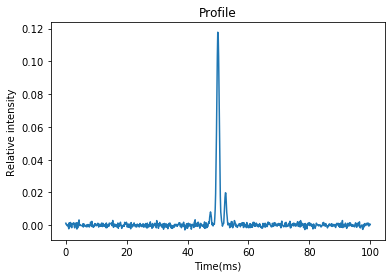

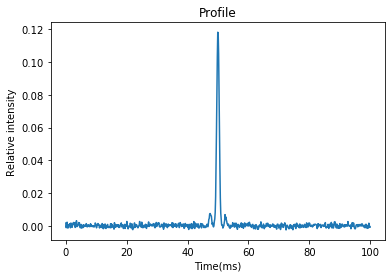

In [5]:
norm.plot()
abnorm.plot()

### Generate profiles

In [6]:
nprofs = 1000

profs = []
#target values
y = []

for i in range(nprofs):
    class_ = np.random.randint(2)
    y.append(class_)
    
    #normal mode
    if class_ == 0:
        norm = fp.fake_profile(amp_1, mu_1, sd_1)
        norm.construct_profile(noise=True, wn_sigma=.1)
        profs.append(norm.profile)
    else:
        abnorm = fp.fake_profile(amp_2, mu_2, sd_2)
        abnorm.construct_profile(noise=True, wn_sigma=.1)
        profs.append(abnorm.profile)
profs = np.array(profs)

### Functions to get features

In [7]:
# Functions copied from http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy
 
def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]
 
def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]
 
def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

In [8]:
def get_dwt_features(profs, wavelet='haar', level=None, nfeatures=None):
    '''Function to decompose each profile, get features at each level and return 
    a feature matrix which will be nprofs X nfeatures.
    
    Parameters
    ----------
    
    profs : 2d array
    NumPy 2d array, each row corresponds to profile data.
    nprofs X nbins
    
    wavelet : str
    Wavelet name to use in wavelet decomposition. Must come from
    pywt.wavelist().
    
    max_level : int
    Maximum level to apply wavelet decomposition to. If None,
    pywt will automatically use maximum level possible.
    
    nfeatures : int
    Number of features. Set to 12 by default if using
    functions from Ahmet Taspinar's website.
    
    Returns
    -------
    matrix : 2d array
    Matrix containing features per profile. nprofs X nfeatures.
    '''
    nprofs = len(profs)
    
    #feature_matrix
    if nfeatures is None:
        if level is None:
            max_level =  pywt.dwt_max_level(len(profs[0]), wavelet)
            nfeatures = len(get_features(profs[0])) * (max_level+1)
        else:
             nfeatures = len(get_features(profs[0])) * (level+1)
    matrix = np.zeros((nprofs, nfeatures))
    
    for i in range(len(profs)):
        features = []
        coeffs = pywt.wavedec(profs[i], wavelet, mode='periodization', level=level)
        for c in coeffs:
            features += get_features(c)
        matrix[i] = features
    
    return matrix

In [9]:
X = get_dwt_features(profs)

### Generate training and test set

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Random Forest Classifier

In [12]:
rnd_clf = RandomForestClassifier(max_leaf_nodes=10)
rnd_clf.fit(X_train, y_train)

cross_val_score(rnd_clf, X_train, y_train, scoring='accuracy')

/Users/MYK/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/MYK/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.47410359, 0.492     , 0.44176707])

In [13]:
#predict on test set
y_pred = rnd_clf.predict(X_test)

In [14]:
#test set performance
accuracy_score(y_test, y_pred)

0.476

### SVM Classifier

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [16]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='linear', C=10))
])

svm_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [17]:
cross_val_score(svm_pipeline, X_train, y_train, cv=10)

array([0.5       , 0.44      , 0.50666667, 0.48      , 0.44      ,
       0.56      , 0.57333333, 0.42666667, 0.44      , 0.47297297])

In [18]:
svm_pipeline.score(X_test, y_test)

0.496

# Both classifiers have accuracy ~50, ie sucks, not better than a purely random classifier